In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [6]:
import os
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

In [7]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [8]:
# Specify the path to the dataset
train_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Training"

# Initialize lists to store file paths and labels
data = []

In [9]:
# Loop through each class folder
for tumor_type in os.listdir(train_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(train_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a training DataFrame from the list
train = pd.DataFrame(data, columns=['image_path', 'label'])
train.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [10]:
# Specify the path to the dataset
test_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Initialize lists to store file paths and labels
data = []

# Loop through each class folder
for tumor_type in os.listdir(test_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(test_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a test DataFrame from the list
test = pd.DataFrame(data, columns=['image_path', 'label'])
test.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


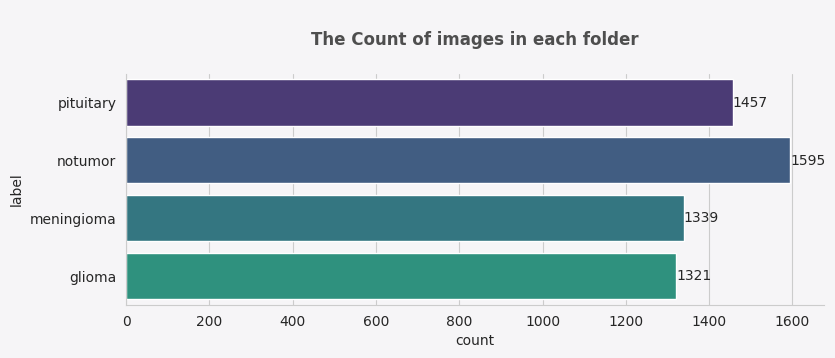

In [11]:
sns.set_palette('viridis')
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(9, 3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["top", "right"]:
    ax.spines[i].set_visible(False)

x = sns.countplot(data=train, y=train["label"])

for container in x.containers:
    x.bar_label(container)

plt.title("\nThe Count of images in each folder\n", weight="bold", color="#4e4e4e")

plt.show()

In [12]:
# Split the training data into training and validation sets
train_data, valid_data = train_test_split(train, test_size=0.1, random_state=42, shuffle = True , stratify=train['label'])

# Display the shape of the resulting sets
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (5140, 2)
Validation set shape: (572, 2)
Testing set shape: (1311, 2)


In [13]:
# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

In [14]:

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',  
    color_mode = 'rgb'
)
valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=False,  
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 5140 validated image filenames belonging to 4 classes.
Found 572 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


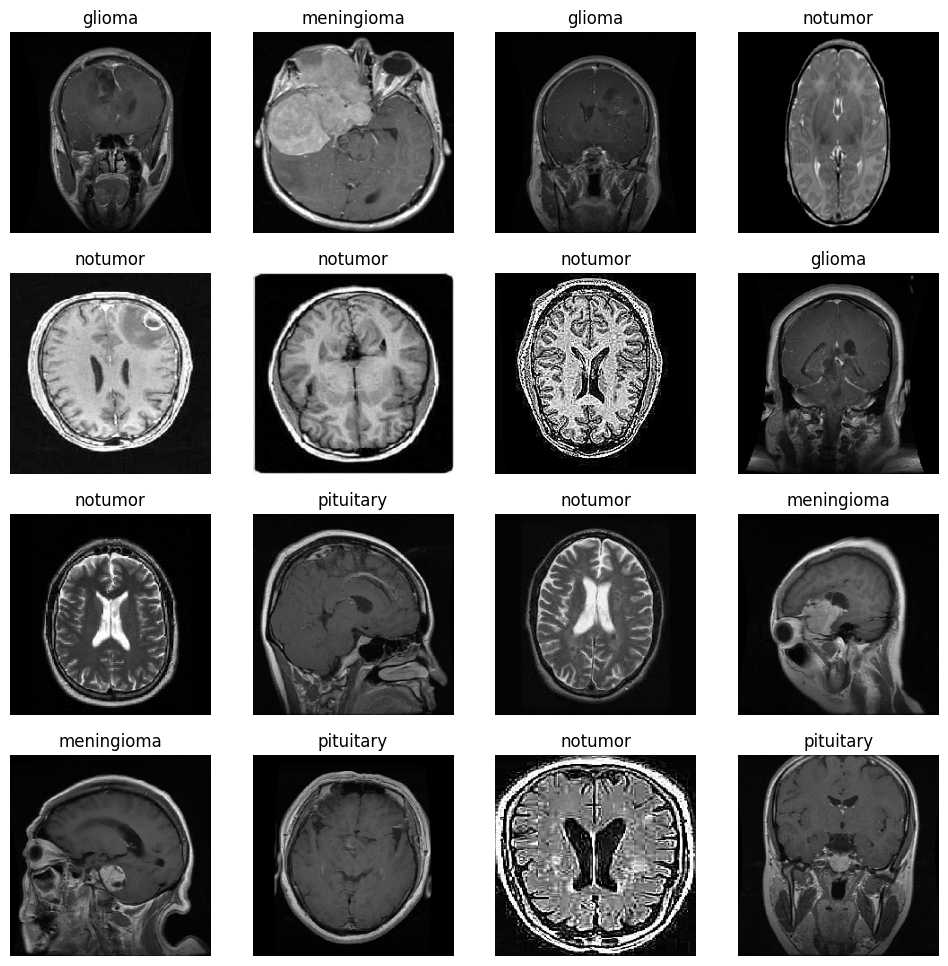

In [15]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(train_generator.class_indices.keys())[label_index]  

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()


In [23]:
# Set the input shape based on the image size you choose
input_shape = (224, 224, 3)  


# Initialize the CNN
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # Output layer with 4 classes

# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model with learning rate scheduling and early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=12,  # Adjust the number of epochs as needed
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Epoch 1/12
  3/322 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.1910 - loss: 1.9880 

W0000 00:00:1709997748.596846     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/322 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.3182 - loss: 1.5845

W0000 00:00:1709997752.114069     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6333 - loss: 0.8782

W0000 00:00:1709997766.365635     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6340 - loss: 0.8767 - val_accuracy: 0.8846 - val_loss: 0.3465
Epoch 2/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/12


W0000 00:00:1709997768.150920     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8654 - loss: 0.3586 - val_accuracy: 0.9178 - val_loss: 0.2129
Epoch 4/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9178 - loss: 0.2084 - val_accuracy: 0.9510 - val_loss: 0.1526
Epoch 6/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9531 - loss: 0.1330 - val_accuracy: 0.9580 - val_loss: 0.1185
Epoch 8/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9650 - loss: 0.0961 - val_accuracy: 0.9441 - val_loss: 0.1839
Epoch 10/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 40us/step - 

In [26]:
# Evaluate the model on the training set
train_score = model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

322/322 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9890 - loss: 0.0381


W0000 00:00:1710000485.911486     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Loss: 0.03769328445196152, Training Accuracy: 0.9892995953559875
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9706 - loss: 0.1089
Test Loss: 0.1788039356470108, Test Accuracy: 0.9481312036514282


W0000 00:00:1710000498.111722     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [28]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds , axis = 1)

 5/82 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

W0000 00:00:1710000725.146224     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step


W0000 00:00:1710000729.077473     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


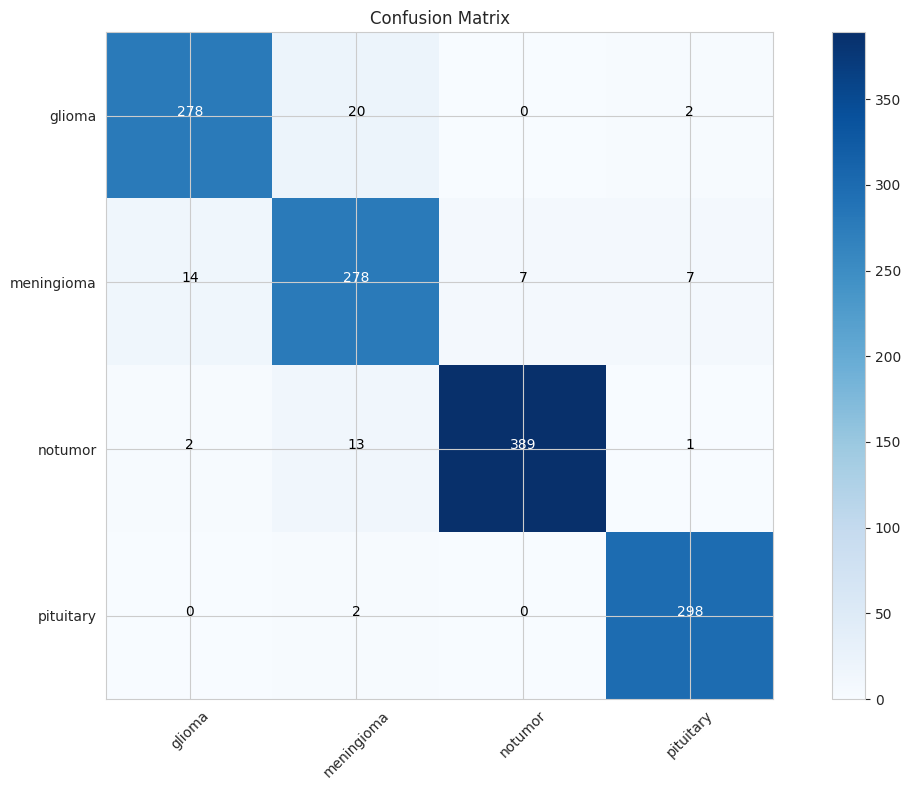

In [30]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

In [38]:
#Classification Report
print(classification_report(test_generator.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       300
  meningioma       0.89      0.91      0.90       306
     notumor       0.98      0.96      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



***Transfer Learning****

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the ResNet50 base
tf_model = Sequential()
tf_model.add(base_model)
tf_model.add(Flatten())
tf_model.add(Dense(512, activation='relu'))
tf_model.add(Dropout(0.5))
tf_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for brain tumor types

# Compile the model
tf_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
tf_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
# Train the model
history = tf_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=14,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Epoch 1/14
  2/322 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.2188 - loss: 9.3747   

W0000 00:00:1710002035.187732     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


252/322 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4608 - loss: 6.7591

W0000 00:00:1710002056.266791     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4686 - loss: 5.8413

W0000 00:00:1710002064.480081     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.4686 - loss: 5.8306 - val_accuracy: 0.5420 - val_loss: 1.0494
Epoch 2/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/14


W0000 00:00:1710002071.383746     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.4627 - loss: 1.1367 - val_accuracy: 0.5245 - val_loss: 1.0788
Epoch 4/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.4535 - loss: 1.1162 - val_accuracy: 0.4843 - val_loss: 1.0369
Epoch 6/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.4583 - loss: 1.0978 - val_accuracy: 0.6661 - val_loss: 0.9801
Epoch 8/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.4779 - loss: 1.0910 - val_accuracy: 0.6976 - val_loss: 0.9249
Epoch 10/14
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - 

In [48]:
from tensorflow.keras.applications import VGG19

# Load the VGG19 model with pre-trained weights
base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model2.layers:
    layer.trainable = False

# Create a new model on top of the VGG19 base
VGG_model = Sequential()
VGG_model.add(base_model2)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(Dropout(0.3))
VGG_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for brain tumor types

# Compile the model
VGG_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
VGG_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [49]:
# Train the model
history = VGG_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
)

Epoch 1/20
  2/322 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4688 - loss: 4.7064   

W0000 00:00:1710002600.351976     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/322 ━━━━━━━━━━━━━━━━━━━━ 1:30 317ms/step - accuracy: 0.4282 - loss: 5.3046

W0000 00:00:1710002611.002549     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6681 - loss: 1.8267

W0000 00:00:1710002635.522665     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 72s 161ms/step - accuracy: 0.6684 - loss: 1.8237 - val_accuracy: 0.8986 - val_loss: 0.2920
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


W0000 00:00:1710002652.000705     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


322/322 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - accuracy: 0.8659 - loss: 0.3491 - val_accuracy: 0.8794 - val_loss: 0.3472
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.8994 - loss: 0.2777 - val_accuracy: 0.9318 - val_loss: 0.2009
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9133 - loss: 0.2397 - val_accuracy: 0.8934 - val_loss: 0.2458
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9096 - loss: 0.2508 - val_accuracy: 0.9108 - val_loss: 0.2979
Epoch 10/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - 

In [50]:
# Evaluate the model on the training set
train_score = VGG_model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the model on the test set
test_score = VGG_model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

322/322 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.9701 - loss: 0.0797


W0000 00:00:1710003033.802774     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training Loss: 0.08115322142839432, Training Accuracy: 0.9694552421569824
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.9667 - loss: 0.0987
Test Loss: 0.20195351541042328, Test Accuracy: 0.9282990097999573


W0000 00:00:1710003057.200867     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [51]:
preds = VGG_model.predict(test_generator)

y_pred = np.argmax(preds , axis = 1)

 3/82 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step  

W0000 00:00:1710003195.650944     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step


W0000 00:00:1710003202.255862     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


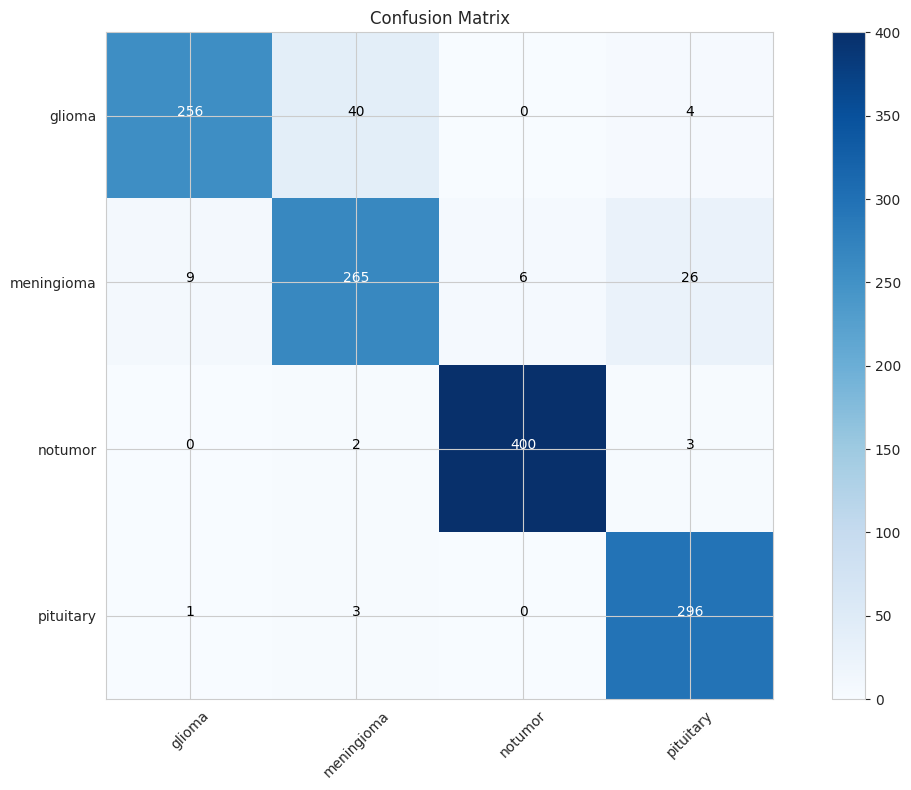

In [52]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

In [53]:
#Classification Report
print(classification_report(test_generator.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.96      0.85      0.90       300
  meningioma       0.85      0.87      0.86       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311

